# Quickstart Example with Synthetic Slate Bandit Data
---
This notebook provides an example of conducting OPE of several different evaluation policies with synthetic slate bandit feedback data.

Our example with synthetic bandit data contains the follwoing four major steps:
- (1) Synthetic Slate Data Generation
- (2) Evaluation Policy Definition (Random Policy)
- (3) Off-Policy Evaluation
- (4) Evaluation of OPE Estimators

The second step could be replaced by some Off-Policy Learning (OPL) step, but obp still does not implement any OPL module for slate bandit data.

Please see [../examples/synthetic](../synthetic) for a more sophisticated example of the evaluation of OPE with synthetic slate bandit data.

In [36]:
import numpy as np
import pandas as pd
# import open bandit pipeline (obp)
import obp

from obp.ope import SlateStandardIPS, SlateIndependentIPS, SlateRecursiveIPS, SlateOffPolicyEvaluation
from obp.dataset import (
    logistic_reward_function,
    linear_behavior_policy_logit,
    SyntheticSlateBanditDataset,
)

In [18]:
from itertools import  product
from copy import deepcopy

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# obp version
print(obp.__version__)

0.4.0


## (1) Synthetic Slate Data Generation
We prepare easy-to-use synthetic slate data generator: `SyntheticSlateBanditDataset` class in the dataset module.

It takes the following arguments as inputs and generates a synthetic bandit dataset that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.
- length of a list of actions recommended in each slate. (`len_list`)
- number of unique actions (`n_unique_actions`)
- dimension of context vectors (`dim_context`)
- reward type (`reward_type`)
- reward structure (`reward_structure`)
- click model (`click_model`)
- base_reward function (`base_reward_function`)
- behavior policy (`behavior_policy_function`) 

In [3]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic function` as the reward function and `linear_behavior_policy` as the behavior policy.
# one can define their own reward function and behavior policy such as nonlinear ones. 

n_unique_action=10
len_list = 3
dim_context = 2
reward_type = "binary"
reward_structure="cascade_additive"
click_model=None
random_state=12345
behavior_policy_function=linear_behavior_policy_logit
base_reward_function=logistic_reward_function

dataset = SyntheticSlateBanditDataset(
    n_unique_action=n_unique_action,
    len_list=len_list,
    dim_context=dim_context,
    reward_type=reward_type, # 'binary' or 'continuous'
    reward_structure=reward_structure, # 'cascade_additive', 'cascade_exponential', 'independent', 'standard_additive', or 'standard_exponential'
    click_model=click_model, # None, 'pbm', or 'cascade'
    random_state=random_state,
    behavior_policy_function=behavior_policy_function,
    base_reward_function=base_reward_function,
)
# obtain training and test sets of synthetic logged bandit feedback
n_rounds_test = 1000
bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_test, return_pscore_item_position=True)

# `bandit_feedback` is a dictionary storing synthetic logged bandit feedback
bandit_feedback_test

[sample_action_and_obtain_pscore]: 100%|██████████| 1000/1000 [00:52<00:00, 18.87it/s]


{'n_rounds': 1000,
 'n_unique_action': 10,
 'slate_id': array([  0,   0,   0, ..., 999, 999, 999]),
 'context': array([[-0.20470766,  0.47894334],
        [-0.51943872, -0.5557303 ],
        [ 1.96578057,  1.39340583],
        ...,
        [ 1.26953635, -1.3414933 ],
        [-0.29333288, -0.2424589 ],
        [-3.05698974,  1.91840302]]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'action': array([7, 4, 2, ..., 1, 9, 2]),
 'position': array([0, 1, 2, ..., 0, 1, 2]),
 'reward': array([1, 0, 0, ..., 1, 0, 0]),
 'expected_reward_factual': array([9.99929232e-01, 8.15725154e-04, 6.53987540e-01, ...,
        9.99998964e

## (2) Evaluation Policy Definition (Off-Policy Learning)
 After generating synthetic data, we now define evaluation policy.

In [4]:
# define Uniform Random Policy as a baseline evaluation policy
random_behavior_dataset = SyntheticSlateBanditDataset(
    n_unique_action=n_unique_action,
    len_list=len_list,
    dim_context=dim_context,
    reward_type=reward_type,
    reward_structure=reward_structure,
    click_model=click_model,
    random_state=random_state,
    behavior_policy_function=None,
    base_reward_function=base_reward_function,
)

# compute the factual action choice probabililties for the test set of the synthetic logged bandit feedback
random_behavior_feedback = random_behavior_dataset.obtain_batch_bandit_feedback(
    n_rounds=n_rounds_test,
    return_pscore_item_position=True,
    return_exact_uniform_pscore_item_position=True
)

[sample_action_and_obtain_pscore]: 100%|██████████| 1000/1000 [00:00<00:00, 4874.11it/s]


## (3) Off-Policy Evaluation (OPE)
Our next step is OPE which attempts to estimate the performance of evaluation policies using the logged bandit feedback and OPE estimators.

Here, we use the **SlateStandardIPS (SIPS)**, **SlateIndependentIPS (IIPS)**, and **SlateRecursiveIPS (RIPS)** estimators and visualize the OPE results.

In [5]:
# estimate the policy value of the evaluation policies based on their action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument

sips = SlateStandardIPS(len_list=len_list)
iips = SlateIndependentIPS(len_list=len_list)
rips = SlateRecursiveIPS(len_list=len_list)

ope = SlateOffPolicyEvaluation(
    bandit_feedback=bandit_feedback_test,
    ope_estimators=[sips, iips, rips]
)

          mean  95.0% CI (lower)  95.0% CI (upper)
sips  1.816407          1.751910          1.881746
iips  1.911399          1.867719          1.951868
rips  1.830078          1.779988          1.886216 



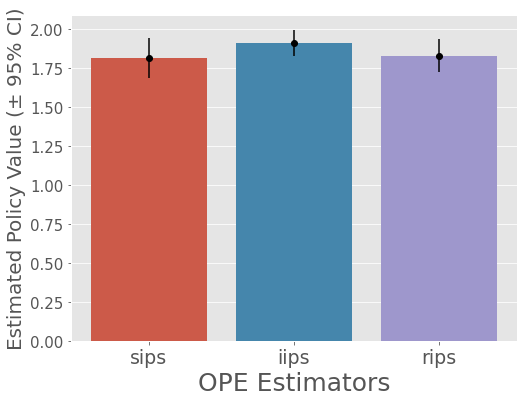

In [7]:
# estimate the policy value of uniform random evaluation policy
estimated_policy_value_a, estimated_interval_a = ope.summarize_off_policy_estimates(
    evaluation_policy_pscore=random_behavior_feedback["pscore"],
    evaluation_policy_pscore_item_position=random_behavior_feedback["pscore_item_position"],
    evaluation_policy_pscore_cascade=random_behavior_feedback["pscore_cascade"],
    alpha=0.05,
    n_bootstrap_samples=100,
    random_state=12345
)
print(estimated_interval_a, '\n')
# visualize estimated policy values of Irandom evaluation policy by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    evaluation_policy_pscore=random_behavior_feedback["pscore"],
    evaluation_policy_pscore_item_position=random_behavior_feedback["pscore_item_position"],
    evaluation_policy_pscore_cascade=random_behavior_feedback["pscore_cascade"],
    alpha=0.05,
    n_bootstrap_samples=100, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

We can observe that the variance of three estimators is as follows: `sips > rips > iips`.

## (4) Evaluation of OPE estimators
Our filan step is **the evaluation of OPE**, which evaluates and compares the estimation accuracy of OPE estimators.

We obtain a policy value by generating synthetic dataset with the policy.

In [9]:
# we first calculate the policy values of the three evaluation policies using the expected rewards of the test data
policy_names = ["Behavior policy", "Evaluation policy (Uniform Random)"]
for name, feedback in zip(policy_names, [bandit_feedback_test, random_behavior_feedback]):
    true_policy_value = feedback["reward"].sum() / np.unique(feedback["slate_id"]).shape[0]
    print(f'policy value of {name}: {true_policy_value}')

policy value of Behavior policy: 1.894
policy value of Evaluation policy (Uniform Random): 1.858


Using the above policy values, we evaluate the estimation accuracy of the OPE estimators.

In [10]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values of random policy and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_for_random = ope.summarize_estimators_comparison(
    ground_truth_policy_value=random_behavior_feedback["reward"].sum() / np.unique(random_behavior_feedback["slate_id"]).shape[0],
    evaluation_policy_pscore=random_behavior_feedback["pscore"],
    evaluation_policy_pscore_item_position=random_behavior_feedback["pscore_item_position"],
    evaluation_policy_pscore_cascade=random_behavior_feedback["pscore_cascade"],    
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_for_random

,relative-ee
sips,0.019897
iips,0.030333
rips,0.012113


We can observe that the performance of three estimators is as follows: `rips > sips > iips`.

Please see [../examples/synthetic](../synthetic) for a more sophisticated example of the evaluation of OPE with synthetic slate bandit data.

## (5) Advanced Evaluation of OPE Estimators using various types of reward assumptions

The performance of slate OPE estimators could depend on the reward assumptions.
1. With cascading reward structure, RIPS should perform best.
2. With independent reward structure, IIPS should perform best.
3. With standard reward structure, SIPS should perform best.

The first hypothesis was observed in the previous section.

In [11]:
reward_structures = ['cascade_additive', 'cascade_exponential', 'independent', 'standard_additive',  'standard_exponential']
click_models = [None, 'pbm', 'cascade']

In [16]:
for i, j in product(reward_structures, click_models[:]):
    print(i, j)

cascade_additive None
cascade_additive pbm
cascade_additive cascade
cascade_exponential None
cascade_exponential pbm
cascade_exponential cascade
independent None
independent pbm
independent cascade
standard_additive None
standard_additive pbm
standard_additive cascade
standard_exponential None
standard_exponential pbm
standard_exponential cascade


In [32]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic function` as the reward function and `linear_behavior_policy` as the behavior policy.
# we generate dataset with various types of reward structures and click models

bandit_feedbacks = []

for reward_structure, click_model in product(reward_structures, click_models):
    dataset_ = SyntheticSlateBanditDataset(
        n_unique_action=n_unique_action,
        len_list=len_list,
        dim_context=dim_context,
        reward_type=reward_type, # 'binary' or 'continuous'
        reward_structure=reward_structure, # 'cascade_additive', 'cascade_exponential', 'independent', 'standard_additive', or 'standard_exponential'
        click_model=click_model, # None, 'pbm', or 'cascade'
        random_state=random_state,
        behavior_policy_function=behavior_policy_function,
        base_reward_function=base_reward_function,
    )
    # obtain training and test sets of synthetic logged bandit feedback
    n_rounds_test = 1000
    bandit_feedback_test_ = dataset_.obtain_batch_bandit_feedback(n_rounds=n_rounds_test, return_pscore_item_position=True)
    bandit_feedback_test_["reward_structure"] = reward_structure
    bandit_feedback_test_["click_model"] = click_model

    # `bandit_feedback` is a dictionary storing synthetic logged bandit feedback
    bandit_feedbacks.append(deepcopy(bandit_feedback_test_))

[sample_reward_of_cascade_model]: 100%|██████████| 1000/1000 [00:00<00:00, 902388.98it/s]


In [33]:
len(bandit_feedbacks)

15

In [54]:
# evaluate the estimation performances of OPE estimators with various types of reward assumptions
# by comparing the estimated policy values of random policy and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 

estimated_policy_value_df = pd.DataFrame()

for feedback in bandit_feedbacks:
    ope_ = SlateOffPolicyEvaluation(
        bandit_feedback=feedback,
        ope_estimators=[sips, iips, rips]
    )
    # define Uniform Random Policy as a baseline evaluation policy
    random_behavior_dataset_ = SyntheticSlateBanditDataset(
        n_unique_action=n_unique_action,
        len_list=len_list,
        dim_context=dim_context,
        reward_type=reward_type,
        reward_structure=feedback["reward_structure"],
        click_model=feedback["click_model"],
        random_state=random_state,
        behavior_policy_function=None,
        base_reward_function=base_reward_function,
    )

    # compute the factual action choice probabililties for the test set of the synthetic logged bandit feedback
    random_behavior_feedback_ = random_behavior_dataset_.obtain_batch_bandit_feedback(
        n_rounds=n_rounds_test,
        return_pscore_item_position=True,
        return_exact_uniform_pscore_item_position=True
    )
    relative_ee_for_random = ope_.summarize_estimators_comparison(
        ground_truth_policy_value=random_behavior_feedback_["reward"].sum() / np.unique(random_behavior_feedback_["slate_id"]).shape[0],
        evaluation_policy_pscore=random_behavior_feedback_["pscore"],
        evaluation_policy_pscore_item_position=random_behavior_feedback_["pscore_item_position"],
        evaluation_policy_pscore_cascade=random_behavior_feedback_["pscore_cascade"],    
        metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
    )

    # estimation performances of the three estimators (lower means accurate)
    relative_ee_for_random
    relative_ee_for_random["reward_structure"] = feedback["reward_structure"]
    relative_ee_for_random["click_model"] = feedback["click_model"]
    estimated_policy_value_df = pd.concat([estimated_policy_value_df, relative_ee_for_random])

[sample_reward_of_cascade_model]: 100%|██████████| 1000/1000 [00:00<00:00, 890699.51it/s]


In [55]:
estimated_policy_value_df["reward_assumption"] =\
    estimated_policy_value_df["reward_structure"] + "_" + estimated_policy_value_df["click_model"].fillna("None")

In [56]:
estimated_policy_value_df

,relative-ee,reward_structure,click_model,reward_assumption
sips,0.019897,cascade_additive,None,cascade_additive_None
iips,0.030333,cascade_additive,None,cascade_additive_None
rips,0.012113,cascade_additive,None,cascade_additive_None
sips,0.009804,cascade_additive,pbm,cascade_additive_pbm
iips,0.025440,cascade_additive,pbm,cascade_additive_pbm
rips,0.003346,cascade_additive,pbm,cascade_additive_pbm
sips,0.024432,cascade_additive,cascade,cascade_additive_cascade
iips,0.015792,cascade_additive,cascade,cascade_additive_cascade
rips,0.021359,cascade_additive,cascade,cascade_additive_cascade
sips,0.026002,cascade_exponential,None,cascade_exponential_None


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'cascade_additive_None'),
  Text(1, 0, 'cascade_additive_pbm'),
  Text(2, 0, 'cascade_additive_cascade'),
  Text(3, 0, 'cascade_exponential_None'),
  Text(4, 0, 'cascade_exponential_pbm'),
  Text(5, 0, 'cascade_exponential_cascade'),
  Text(6, 0, 'independent_None'),
  Text(7, 0, 'independent_pbm'),
  Text(8, 0, 'independent_cascade'),
  Text(9, 0, 'standard_additive_None'),
  Text(10, 0, 'standard_additive_pbm'),
  Text(11, 0, 'standard_additive_cascade'),
  Text(12, 0, 'standard_exponential_None'),
  Text(13, 0, 'standard_exponential_pbm'),
  Text(14, 0, 'standard_exponential_cascade')])

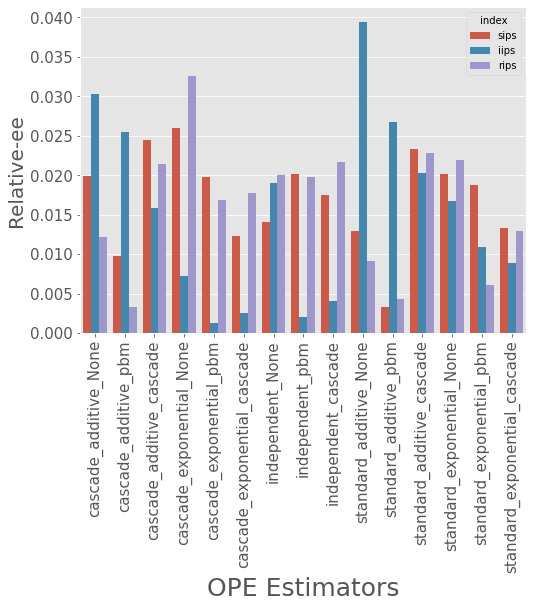

In [57]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    data=estimated_policy_value_df.reset_index(),
    hue="index",
    x="reward_assumption",
    y="relative-ee",
    ax=ax,
    ci=None,
)
plt.xlabel("OPE Estimators", fontsize=25)
plt.ylabel(
    f"Relative-ee", fontsize=20
)
plt.yticks(fontsize=15)
plt.xticks(rotation=90, fontsize=15)

Unfortunately, we cannot say that our hypotheses are true by this experiment.

We are going to add `n_rounds` and run experiments by using various random seeds.